# 

In [3]:
# ---------------------------------------------
# 1. Import Necessary Libraries
# ---------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score



# Optional: For saving the model
import joblib

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [ ]:

# ---------------------------------------------
# 2. Load Datasets
# ---------------------------------------------

# Replace 'merged_features_drop_cleaned_train_data.csv' and 'merged_features_drop_cleaned_test_data.csv'
# with your actual file paths if they are located elsewhere
train_df = pd.read_csv('merged_features_drop_cleaned_train_data.csv')
test_df = pd.read_csv('merged_features_drop_cleaned_test_data.csv')

# Display initial information about the datasets
print("Training Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# ---------------------------------------------
# 3. Handle Missing 'departure.actualTime' in Test Dataset
# ---------------------------------------------

# Check if 'departure.actualTime' exists in test_df
if 'departure.actualTime' not in test_df.columns:
    print("\nColumn 'departure.actualTime' not found in test dataset. Imputing with 'departure.scheduledTime'.")
    # Impute 'departure.actualTime' with 'departure.scheduledTime' assuming no delay
    test_df['departure.actualTime'] = test_df['departure.scheduledTime']
else:
    # Ensure 'departure.actualTime' is in datetime format
    test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')
    # Fill missing 'departure.actualTime' with 'departure.scheduledTime'
    test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# ---------------------------------------------
# 4. Datetime Conversion
# ---------------------------------------------

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Training Data
train_df['departure.scheduledTime'] = pd.to_datetime(train_df['departure.scheduledTime'], errors='coerce')
train_df['departure.actualTime'] = pd.to_datetime(train_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Training Data
train_df['departure.actualTime'].fillna(train_df['departure.scheduledTime'], inplace=True)

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Test Data
test_df['departure.scheduledTime'] = pd.to_datetime(test_df['departure.scheduledTime'], errors='coerce')
test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Test Data
test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# Verify the conversion
print("\nAfter Datetime Conversion:")
print("Training Data 'departure.scheduledTime' dtype:", train_df['departure.scheduledTime'].dtype)
print("Training Data 'departure.actualTime' dtype:", train_df['departure.actualTime'].dtype)
print("Test Data 'departure.scheduledTime' dtype:", test_df['departure.scheduledTime'].dtype)
print("Test Data 'departure.actualTime' dtype:", test_df['departure.actualTime'].dtype)

# ---------------------------------------------
# 5. Feature Engineering: Extract Datetime Features
# ---------------------------------------------

# Function to extract datetime features
def extract_datetime_features(df):
    df['scheduled_hour'] = df['departure.scheduledTime'].dt.hour
    df['scheduled_day'] = df['departure.scheduledTime'].dt.day
    df['scheduled_month'] = df['departure.scheduledTime'].dt.month
    df['scheduled_weekday'] = df['departure.scheduledTime'].dt.weekday
    
    df['actual_hour'] = df['departure.actualTime'].dt.hour
    df['actual_day'] = df['departure.actualTime'].dt.day
    df['actual_month'] = df['departure.actualTime'].dt.month
    df['actual_weekday'] = df['departure.actualTime'].dt.weekday
    
    # Calculate delay in minutes
    df['calculated_departure_delay'] = (df['departure.actualTime'] - df['departure.scheduledTime']).dt.total_seconds() / 60
    df['calculated_departure_delay'] = df['calculated_departure_delay'].clip(lower=0)  # Ensure no negative delays

# Apply the function to both train and test datasets
extract_datetime_features(train_df)
extract_datetime_features(test_df)


In [11]:
# ---------------------------------------------
# 1. Import Necessary Libraries
# ---------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.ensemble import RandomForestClassifier, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_recall_fscore_support
)

# For saving the model
import joblib

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51871 entries, 0 to 51870
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status                     51871 non-null  int64  
 1   departure.iataCode         51871 non-null  object 
 2   departure.icaoCode         51871 non-null  object 
 3   departure.terminal         51871 non-null  object 
 4   departure.scheduledTime    51871 non-null  object 
 5   departure.estimatedTime    51871 non-null  object 
 6   departure.actualTime       51871 non-null  object 
 7   departure.estimatedRunway  51871 non-null  object 
 8   departure.actualRunway     51871 non-null  object 
 9   arrival.scheduledTime      51871 non-null  object 
 10  arrival.estimatedTime      51871 non-null  object 
 11  airline.iataCode           51871 non-null  object 
 12  airline.icaoCode           51871 non-null  object 
 13  flight.number             

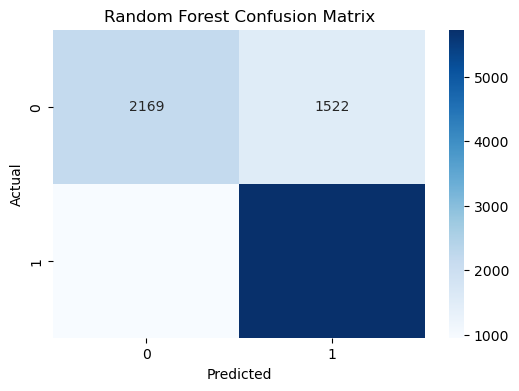

Accuracy: 0.7611
ROC-AUC Score: 0.8152

Training and evaluating model: Decision Tree

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3691
           1       0.82      0.81      0.82      6684

    accuracy                           0.76     10375
   macro avg       0.74      0.74      0.74     10375
weighted avg       0.76      0.76      0.76     10375



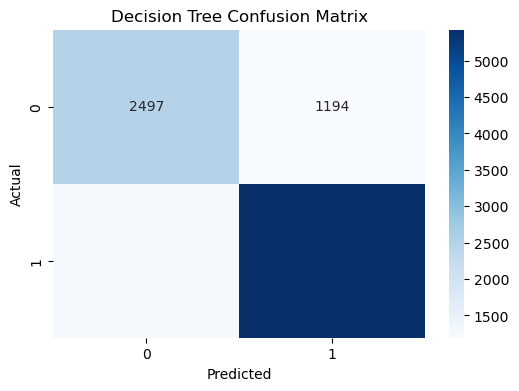

Accuracy: 0.7635
ROC-AUC Score: 0.7450

Training and evaluating model: Support Vector Machine

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.71      0.27      0.39      3691
           1       0.70      0.94      0.80      6684

    accuracy                           0.70     10375
   macro avg       0.71      0.61      0.60     10375
weighted avg       0.70      0.70      0.66     10375



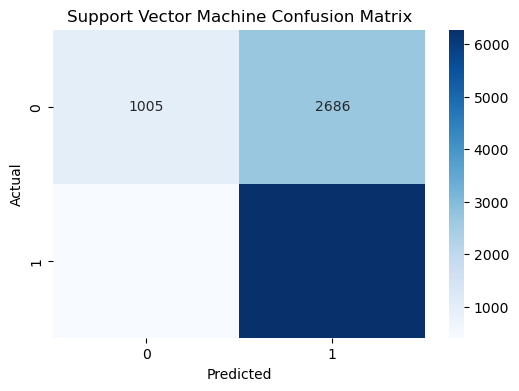

Accuracy: 0.7018
ROC-AUC Score: 0.7647

Model Performance Comparison:
                    Model  Accuracy   ROC-AUC
0           Random Forest  0.761060  0.815225
2  Support Vector Machine  0.701783  0.764740
1           Decision Tree  0.763470  0.745032


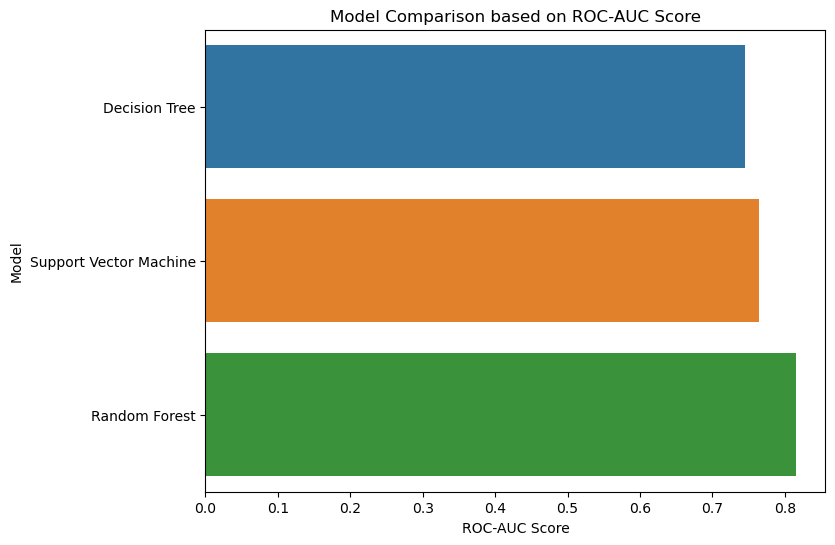


Best Model Selected: Random Forest with ROC-AUC Score: 0.8152

Making predictions on the test dataset using the best model: Random Forest

Trimming submission from 14982 to 12914 entries.
Submission file 'kaggle_submission_classification.csv' saved.
Trained Random Forest model saved as 'best_model_random_forest.pkl'.


In [5]:
# ---------------------------------------------
# 1. Import Necessary Libraries
# ---------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.ensemble import RandomForestClassifier, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_recall_fscore_support
)

# For saving the model
import joblib

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ---------------------------------------------
# 2. Load Datasets
# ---------------------------------------------

# Replace with your actual file paths if they are located elsewhere
train_df = pd.read_csv('merged_features_drop_cleaned_train_data.csv')
test_df = pd.read_csv('merged_features_drop_cleaned_test_data.csv')

# Display initial information about the datasets
print("Training Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# ---------------------------------------------
# 3. Handle Missing 'departure.actualTime' in Test Dataset
# ---------------------------------------------

# Check if 'departure.actualTime' exists in test_df
if 'departure.actualTime' not in test_df.columns:
    print("\nColumn 'departure.actualTime' not found in test dataset. Imputing with 'departure.scheduledTime'.")
    # Impute 'departure.actualTime' with 'departure.scheduledTime' assuming no delay
    test_df['departure.actualTime'] = test_df['departure.scheduledTime']
else:
    # Ensure 'departure.actualTime' is in datetime format
    test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')
    # Fill missing 'departure.actualTime' with 'departure.scheduledTime'
    test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# ---------------------------------------------
# 4. Datetime Conversion
# ---------------------------------------------

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Training Data
train_df['departure.scheduledTime'] = pd.to_datetime(train_df['departure.scheduledTime'], errors='coerce')
train_df['departure.actualTime'] = pd.to_datetime(train_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Training Data
train_df['departure.actualTime'].fillna(train_df['departure.scheduledTime'], inplace=True)

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Test Data
test_df['departure.scheduledTime'] = pd.to_datetime(test_df['departure.scheduledTime'], errors='coerce')
test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Test Data
test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# Verify the conversion
print("\nAfter Datetime Conversion:")
print("Training Data 'departure.scheduledTime' dtype:", train_df['departure.scheduledTime'].dtype)
print("Training Data 'departure.actualTime' dtype:", train_df['departure.actualTime'].dtype)
print("Test Data 'departure.scheduledTime' dtype:", test_df['departure.scheduledTime'].dtype)
print("Test Data 'departure.actualTime' dtype:", test_df['departure.actualTime'].dtype)

# ---------------------------------------------
# 5. Feature Engineering: Extract Datetime Features
# ---------------------------------------------

# Function to extract datetime features
def extract_datetime_features(df):
    df['scheduled_hour'] = df['departure.scheduledTime'].dt.hour
    df['scheduled_day'] = df['departure.scheduledTime'].dt.day
    df['scheduled_month'] = df['departure.scheduledTime'].dt.month
    df['scheduled_weekday'] = df['departure.scheduledTime'].dt.weekday
    
    df['actual_hour'] = df['departure.actualTime'].dt.hour
    df['actual_day'] = df['departure.actualTime'].dt.day
    df['actual_month'] = df['departure.actualTime'].dt.month
    df['actual_weekday'] = df['departure.actualTime'].dt.weekday
    
    # Calculate delay in minutes
    df['calculated_departure_delay'] = (df['departure.actualTime'] - df['departure.scheduledTime']).dt.total_seconds() / 60
    df['calculated_departure_delay'] = df['calculated_departure_delay'].clip(lower=0)  # Ensure no negative delays

# Apply the function to both train and test datasets
extract_datetime_features(train_df)
extract_datetime_features(test_df)

# ---------------------------------------------
# 6. Define Feature Lists
# ---------------------------------------------

# Define numeric features
numeric_features = [
    'Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min', 
    'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min',
    'Humidity (%) Max', 'Humidity (%) Avg', 'Humidity (%) Min', 
    'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min', 
    'Pressure (in) Max', 'Pressure (in) Avg', 'Pressure (in) Min', 
    'Precipitation (in) Total',
    'scheduled_hour', 'scheduled_day', 'scheduled_month', 'scheduled_weekday',
    'actual_hour', 'actual_day', 'actual_month', 'actual_weekday'
    # 'calculated_departure_delay' is REMOVED to prevent data leakage
]

# Define categorical features
categorical_features = [
    'departure.iataCode', 'departure.icaoCode', 'airline.iataCode'
]

# ---------------------------------------------
# 7. Handle Missing Values and Define Preprocessing Pipelines
# ---------------------------------------------

# Numeric Transformer Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Standardize numeric features
])

# Categorical Transformer Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine Preprocessing for Numeric and Categorical Data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# ---------------------------------------------
# 8. Prepare Feature Matrices and Target Variable
# ---------------------------------------------

# Define feature matrix X and target vector y for training
X = train_df[numeric_features + categorical_features]
y_reg = train_df['departure.delay_minutes']  # Original regression target

# Define binary target variable based on delay threshold
DELAY_THRESHOLD = 0  # Define threshold for delay in minutes
# Criteria:
# 1. delay = 0: on-time (0)
# 2. delay > 0: delayed (1)
train_df['is_delayed'] = (train_df['departure.delay_minutes'] > DELAY_THRESHOLD).astype(int)
y = train_df['is_delayed']  # Binary target

# Check for missing values in the target variable
missing_targets = y.isnull().sum()
if missing_targets > 0:
    print(f"\nWarning: There are {missing_targets} missing values in the binary target variable. Dropping these rows.")
    # Drop rows with missing target variable
    non_null_indices = y.dropna().index
    X = X.loc[non_null_indices]
    y = y.loc[non_null_indices]
else:
    print("\nNo missing values found in the binary target variable.")

# Define feature matrix for test data
X_test = test_df[numeric_features + categorical_features]

# ---------------------------------------------
# 9. Split Data into Training and Validation Sets
# ---------------------------------------------

# Use stratified split to maintain class distribution
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining Set Size:", X_train.shape)
print("Validation Set Size:", X_val.shape)
print("Test Set Size:", X_test.shape)

# ---------------------------------------------
# 10. Define and Train Classification Models
# ---------------------------------------------

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True)
}

# Dictionary to store model performances
model_performance = {}

# Iterate through models, train, and evaluate
for model_name, model in models.items():
    print(f"\nTraining and evaluating model: {model_name}")
    
    # Create Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict on Validation Set
    y_pred = pipeline.predict(X_val)
    
    # For ROC-AUC, we need probability estimates
    if hasattr(model, "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_val)[:,1]
    else:
        # Use decision function or skip ROC-AUC if not available
        y_pred_proba = None
        print(f"Model {model_name} does not support predict_proba. Skipping ROC-AUC.")
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_val, y_pred_proba)
    else:
        roc_auc = np.nan  # Assign NaN if ROC-AUC not available
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')
    precision_class, recall_class, f1_class, _ = precision_recall_fscore_support(y_val, y_pred, average=None)
    
    # Store performance
    model_performance[model_name] = {
        'Pipeline': pipeline,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Precision_Class': precision_class,
        'Recall_Class': recall_class
    }
    
    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_val, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    if not np.isnan(roc_auc):
        print(f"ROC-AUC Score: {roc_auc:.4f}")
    else:
        print("ROC-AUC Score: Not Available")

# ---------------------------------------------
# 11. Compare Models and Select the Best One
# ---------------------------------------------

# Create a DataFrame for model comparison
performance_df = pd.DataFrame({
    'Model': list(model_performance.keys()),
    'Accuracy': [model_performance[m]['Accuracy'] for m in model_performance],
    'ROC-AUC': [model_performance[m]['ROC-AUC'] for m in model_performance]
})

print("\nModel Performance Comparison:")
print(performance_df.sort_values(by='ROC-AUC', ascending=False))

# Plot ROC-AUC scores
plt.figure(figsize=(8,6))
sns.barplot(x='ROC-AUC', y='Model', data=performance_df.sort_values(by='ROC-AUC', ascending=True))
plt.title('Model Comparison based on ROC-AUC Score')
plt.xlabel('ROC-AUC Score')
plt.ylabel('Model')
plt.show()

# Select the best model based on ROC-AUC
# Handle the case where some models might not have ROC-AUC
performance_df_sorted = performance_df.dropna(subset=['ROC-AUC']).sort_values(by='ROC-AUC', ascending=False)
best_model_name = performance_df_sorted.iloc[0]['Model']
best_model_pipeline = model_performance[best_model_name]['Pipeline']

print(f"\nBest Model Selected: {best_model_name} with ROC-AUC Score: {model_performance[best_model_name]['ROC-AUC']:.4f}")

# ---------------------------------------------
# 12. Make Predictions on the Test Dataset
# ---------------------------------------------

# Make predictions using the best model
print(f"\nMaking predictions on the test dataset using the best model: {best_model_name}")
y_pred_test = best_model_pipeline.predict(X_test)

# ---------------------------------------------
# 13. Prepare the Submission File
# ---------------------------------------------

# Prepare the Submission DataFrame
submission_df = pd.DataFrame({
    'ID': range(1, len(test_df) + 1),  # Assuming IDs start from 1
    'Delay': y_pred_test  # Predicted binary delays (0 or 1)
})

# Ensure the Number of Entries matches the expected number
expected_entries = 12914  # Replace with actual expected number if different
actual_entries = len(submission_df)

if actual_entries > expected_entries:
    print(f"\nTrimming submission from {actual_entries} to {expected_entries} entries.")
    submission_df = submission_df.head(expected_entries)
elif actual_entries < expected_entries:
    print(f"\nWarning: Submission has only {actual_entries} entries. Check the test data.")
else:
    print("\nSubmission has the expected number of entries.")

# Save the Submission File in the Required Format
submission_df.to_csv('kaggle_submission_classification22I1374.csv', index=False)
print("Submission file 'kaggle_submission_classification.csv' saved.")

# ---------------------------------------------
# 14. Save the Best Model
# ---------------------------------------------

# Save the trained best model using joblib
model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model_pipeline, model_filename)
print(f"Trained {best_model_name} model saved as '{model_filename}'.")


In [7]:
# ---------------------------------------------
# 13. Prepare the Submission File with "delayed" and "on-time"
# ---------------------------------------------

# Convert the binary predictions to "delayed" and "on-time"
submission_df = pd.DataFrame({
    'ID': range(1, len(test_df) + 1),  # Assuming IDs start from 1
    'Delay': ['delayed' if x == 1 else 'on-time' for x in y_pred_test]  # Convert 1 -> 'delayed', 0 -> 'on-time'
})

# Ensure the Number of Entries matches the expected number
expected_entries = 12914  # Replace with actual expected number if different
actual_entries = len(submission_df)

if actual_entries > expected_entries:
    print(f"\nTrimming submission from {actual_entries} to {expected_entries} entries.")
    submission_df = submission_df.head(expected_entries)
elif actual_entries < expected_entries:
    print(f"\nWarning: Submission has only {actual_entries} entries. Check the test data.")
else:
    print("\nSubmission has the expected number of entries.")

# Save the Submission File in the Required Format
submission_df.to_csv('binaryclassifcation_22i_1374_kaggle_submission_classification_delayed_on_time.csv', index=False)
print("Submission file 'kaggle_submission_classification_delayed_on_time.csv' saved.")



Trimming submission from 14982 to 12914 entries.
Submission file 'kaggle_submission_classification_delayed_on_time.csv' saved.


In [7]:
# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51871 entries, 0 to 51870
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status                     51871 non-null  int64  
 1   departure.iataCode         51871 non-null  object 
 2   departure.icaoCode         51871 non-null  object 
 3   departure.terminal         51871 non-null  object 
 4   departure.scheduledTime    51871 non-null  object 
 5   departure.estimatedTime    51871 non-null  object 
 6   departure.actualTime       51871 non-null  object 
 7   departure.estimatedRunway  51871 non-null  object 
 8   departure.actualRunway     51871 non-null  object 
 9   arrival.scheduledTime      51871 non-null  object 
 10  arrival.estimatedTime      51871 non-null  object 
 11  airline.iataCode           51871 non-null  object 
 12  airline.icaoCode           51871 non-null  object 
 13  flight.number             

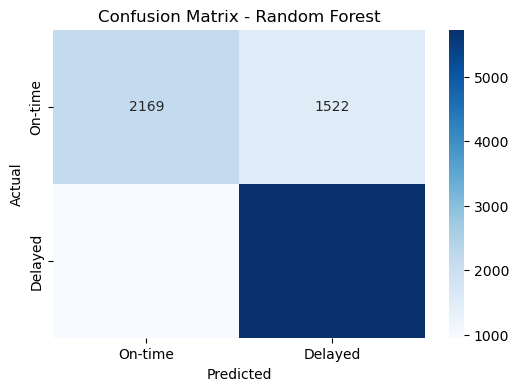

Accuracy: 0.7611
ROC-AUC Score: 0.8152

Training and evaluating model: Decision Tree

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3691
           1       0.82      0.81      0.82      6684

    accuracy                           0.76     10375
   macro avg       0.74      0.74      0.74     10375
weighted avg       0.76      0.76      0.76     10375



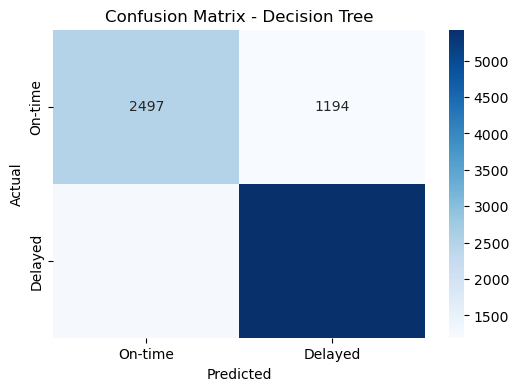

Accuracy: 0.7635
ROC-AUC Score: 0.7450

Training and evaluating model: K-Nearest Neighbors

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.59      0.49      0.53      3691
           1       0.74      0.81      0.77      6684

    accuracy                           0.69     10375
   macro avg       0.66      0.65      0.65     10375
weighted avg       0.69      0.69      0.69     10375



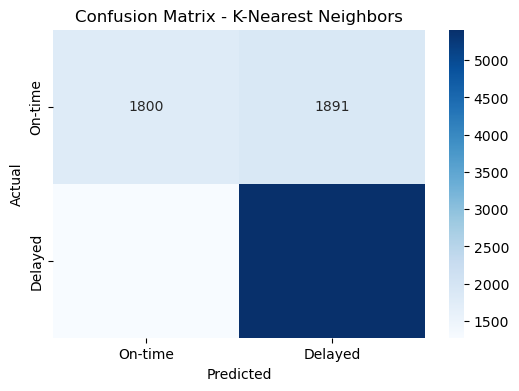

Accuracy: 0.6949
ROC-AUC Score: 0.7163

Starting GridSearchCV for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Best ROC-AUC Score for Random Forest: 0.8077

Starting GridSearchCV for Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters for Decision Tree: {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Best ROC-AUC Score for Decision Tree: 0.7868

Random Forest Cross-Validation ROC-AUC Scores: [0.82076445 0.82398408 0.82546924 0.8174598  0.82534435]
Average Random Forest ROC-AUC Score: 0.8226

Decision Tree Cross-Validation ROC-AUC Scores: [0.79764938 0.78915689 0.79911785 0.79741051 0.79691252]
Average Decision Tree ROC-AUC Score: 0.7960

Model Comparison:
           Model                                     ROC-AUC Score

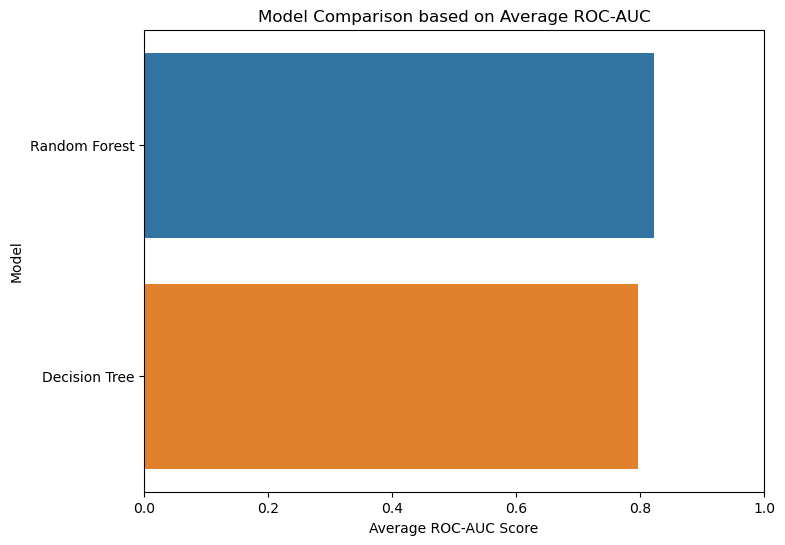


Best Model Selected: Random Forest with Average ROC-AUC Score: 0.8226

Making predictions on the test dataset using the best model: Random Forest

Expected Entries: 12914
Actual Entries: 14982
Trimming submission from 14982 to 12914 entries.
Submission file '02_kaggle_submission_binary_delayed_on_time.csv' saved successfully.

Best model 'Random Forest' saved as 'best_model_random_forest.pkl'.


In [15]:
# ---------------------------------------------
# Phase 3: Analytical and Predictive Tasks
# Binary Classification
# ---------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.ensemble import RandomForestClassifier, DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_recall_fscore_support
)

# For saving the model
import joblib

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ---------------------------------------------
# 1. Load Datasets
# ---------------------------------------------

# Replace with your actual file paths if they are located elsewhere
train_df = pd.read_csv('merged_features_drop_cleaned_train_data.csv')
test_df = pd.read_csv('merged_features_drop_cleaned_test_data.csv')

# Display initial information about the datasets
print("Training Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# ---------------------------------------------
# 2. Handle Missing 'departure.actualTime' in Test Dataset
# ---------------------------------------------

# Check if 'departure.actualTime' exists in test_df
if 'departure.actualTime' not in test_df.columns:
    print("\nColumn 'departure.actualTime' not found in test dataset. Imputing with 'departure.scheduledTime'.")
    # Impute 'departure.actualTime' with 'departure.scheduledTime' assuming no delay
    test_df['departure.actualTime'] = test_df['departure.scheduledTime']
else:
    # Ensure 'departure.actualTime' is in datetime format
    test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')
    # Fill missing 'departure.actualTime' with 'departure.scheduledTime'
    test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# ---------------------------------------------
# 3. Datetime Conversion
# ---------------------------------------------

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Training Data
train_df['departure.scheduledTime'] = pd.to_datetime(train_df['departure.scheduledTime'], errors='coerce')
train_df['departure.actualTime'] = pd.to_datetime(train_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Training Data
train_df['departure.actualTime'].fillna(train_df['departure.scheduledTime'], inplace=True)

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Test Data
test_df['departure.scheduledTime'] = pd.to_datetime(test_df['departure.scheduledTime'], errors='coerce')
test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Test Data
test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# Verify the conversion
print("\nAfter Datetime Conversion:")
print("Training Data 'departure.scheduledTime' dtype:", train_df['departure.scheduledTime'].dtype)
print("Training Data 'departure.actualTime' dtype:", train_df['departure.actualTime'].dtype)
print("Test Data 'departure.scheduledTime' dtype:", test_df['departure.scheduledTime'].dtype)
print("Test Data 'departure.actualTime' dtype:", test_df['departure.actualTime'].dtype)

# ---------------------------------------------
# 4. Feature Engineering: Extract Datetime Features
# ---------------------------------------------

# Function to extract datetime features
def extract_datetime_features(df):
    df['scheduled_hour'] = df['departure.scheduledTime'].dt.hour
    df['scheduled_day'] = df['departure.scheduledTime'].dt.day
    df['scheduled_month'] = df['departure.scheduledTime'].dt.month
    df['scheduled_weekday'] = df['departure.scheduledTime'].dt.weekday
    
    df['actual_hour'] = df['departure.actualTime'].dt.hour
    df['actual_day'] = df['departure.actualTime'].dt.day
    df['actual_month'] = df['departure.actualTime'].dt.month
    df['actual_weekday'] = df['departure.actualTime'].dt.weekday
    
    # Calculate delay in minutes
    df['calculated_departure_delay'] = (df['departure.actualTime'] - df['departure.scheduledTime']).dt.total_seconds() / 60
    df['calculated_departure_delay'] = df['calculated_departure_delay'].clip(lower=0)  # Ensure no negative delays

# Apply the function to both train and test datasets
extract_datetime_features(train_df)
extract_datetime_features(test_df)

# ---------------------------------------------
# 5. Define Feature Lists
# ---------------------------------------------

# Define numeric features
numeric_features = [
    'Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min', 
    'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min',
    'Humidity (%) Max', 'Humidity (%) Avg', 'Humidity (%) Min', 
    'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min', 
    'Pressure (in) Max', 'Pressure (in) Avg', 'Pressure (in) Min', 
    'Precipitation (in) Total',
    'scheduled_hour', 'scheduled_day', 'scheduled_month', 'scheduled_weekday',
    'actual_hour', 'actual_day', 'actual_month', 'actual_weekday'
    # 'calculated_departure_delay' is REMOVED to prevent data leakage
]

# Define categorical features
categorical_features = [
    'departure.iataCode', 'departure.icaoCode', 'airline.iataCode'
]

# ---------------------------------------------
# 6. Handle Missing Values and Define Preprocessing Pipelines
# ---------------------------------------------

# Numeric Transformer Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Standardize numeric features
])

# Categorical Transformer Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine Preprocessing for Numeric and Categorical Data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# ---------------------------------------------
# 7. Prepare Feature Matrices and Target Variable
# ---------------------------------------------

# Define feature matrix X and target vector y for training
X = train_df[numeric_features + categorical_features]
y_reg = train_df['departure.delay_minutes']  # Original regression target

# Define binary target variable based on delay threshold
DELAY_THRESHOLD = 0  # Define threshold for delay in minutes
# Criteria:
# 1. delay = 0: on-time (0)
# 2. delay > 0: delayed (1)
train_df['is_delayed'] = (train_df['departure.delay_minutes'] > DELAY_THRESHOLD).astype(int)
y = train_df['is_delayed']  # Binary target

# Check for missing values in the target variable
missing_targets = y.isnull().sum()
if missing_targets > 0:
    print(f"\nWarning: There are {missing_targets} missing values in the binary target variable. Dropping these rows.")
    # Drop rows with missing target variable
    non_null_indices = y.dropna().index
    X = X.loc[non_null_indices]
    y = y.loc[non_null_indices]
else:
    print("\nNo missing values found in the binary target variable.")

# Define feature matrix for test data
X_test = test_df[numeric_features + categorical_features]

# ---------------------------------------------
# 8. Split Data into Training and Validation Sets
# ---------------------------------------------

# Use stratified split to maintain class distribution
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining Set Size:", X_train.shape)
print("Validation Set Size:", X_val.shape)
print("Test Set Size:", X_test.shape)

# ---------------------------------------------
# Phase 3: Analytical and Predictive Tasks
# Binary Classification
# ---------------------------------------------

# Define Classification Models
classification_models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
}

# Dictionary to store model performances
binary_model_performance = {}

# Iterate through each model, train, and evaluate
for model_name, model in classification_models.items():
    print(f"\nTraining and evaluating model: {model_name}")
    
    # Create Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict on Validation Set
    y_pred = pipeline.predict(X_val)
    
    # Predict Probability for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_val)[:,1]
    else:
        # For models without predict_proba (e.g., KNN with probability=False), skip ROC-AUC
        y_pred_proba = None
        print(f"Model {model_name} does not support predict_proba. ROC-AUC will not be calculated.")
    
    # Calculate Metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_val, y_pred_proba)
    else:
        roc_auc = np.nan  # Assign NaN if ROC-AUC not available
    
    # Store Performance Metrics
    binary_model_performance[model_name] = {
        'Pipeline': pipeline,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }
    
    # Print Classification Report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_val, y_pred))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['On-time', 'Delayed'], 
                yticklabels=['On-time', 'Delayed'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Print Metrics
    print(f"Accuracy: {accuracy:.4f}")
    if not np.isnan(roc_auc):
        print(f"ROC-AUC Score: {roc_auc:.4f}")
    else:
        print("ROC-AUC Score: Not Available")

# ---------------------------------------------
# Phase 4: Model Optimization and Evaluation
# Hyperparameter Tuning for Random Forest and Decision Tree
# ---------------------------------------------

# Define parameter grids for Random Forest and Decision Tree
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_dt = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for Random Forest
print("\nStarting GridSearchCV for Random Forest...")
grid_search_rf = GridSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV for Random Forest
grid_search_rf.fit(X_train, y_train)

# Best parameters and score for Random Forest
print(f"\nBest Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best ROC-AUC Score for Random Forest: {grid_search_rf.best_score_:.4f}")

# Initialize GridSearchCV for Decision Tree
print("\nStarting GridSearchCV for Decision Tree...")
grid_search_dt = GridSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    param_grid=param_grid_dt,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV for Decision Tree
grid_search_dt.fit(X_train, y_train)

# Best parameters and score for Decision Tree
print(f"\nBest Parameters for Decision Tree: {grid_search_dt.best_params_}")
print(f"Best ROC-AUC Score for Decision Tree: {grid_search_dt.best_score_:.4f}")

# ---------------------------------------------
# Cross-Validation for Optimized Models
# ---------------------------------------------

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Best Random Forest Model
best_rf = grid_search_rf.best_estimator_
rf_cv_scores = cross_val_score(best_rf, X, y, cv=skf, scoring='roc_auc')
print(f"\nRandom Forest Cross-Validation ROC-AUC Scores: {rf_cv_scores}")
print(f"Average Random Forest ROC-AUC Score: {rf_cv_scores.mean():.4f}")

# Best Decision Tree Model
best_dt = grid_search_dt.best_estimator_
dt_cv_scores = cross_val_score(best_dt, X, y, cv=skf, scoring='roc_auc')
print(f"\nDecision Tree Cross-Validation ROC-AUC Scores: {dt_cv_scores}")
print(f"Average Decision Tree ROC-AUC Score: {dt_cv_scores.mean():.4f}")

# ---------------------------------------------
# Model Comparison and Selection
# ---------------------------------------------

# Compile cross-validation scores into a DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree'],
    'ROC-AUC Scores': [rf_cv_scores, dt_cv_scores],
    'Average ROC-AUC': [rf_cv_scores.mean(), dt_cv_scores.mean()]
})

print("\nModel Comparison:")
print(comparison_df)

# Plot Average ROC-AUC Scores
plt.figure(figsize=(8,6))
sns.barplot(x='Average ROC-AUC', y='Model', data=comparison_df)
plt.title('Model Comparison based on Average ROC-AUC')
plt.xlabel('Average ROC-AUC Score')
plt.ylabel('Model')
plt.xlim(0,1)
plt.show()

# Select the best model
if rf_cv_scores.mean() > dt_cv_scores.mean():
    best_model = best_rf
    best_model_name = 'Random Forest'
else:
    best_model = best_dt
    best_model_name = 'Decision Tree'

print(f"\nBest Model Selected: {best_model_name} with Average ROC-AUC Score: {comparison_df.loc[comparison_df['Model'] == best_model_name, 'Average ROC-AUC'].values[0]:.4f}")

# ---------------------------------------------
# Phase 5: Model Testing and Kaggle Submission
# Make Predictions on Test Dataset
# ---------------------------------------------

# Predict using the best model
print(f"\nMaking predictions on the test dataset using the best model: {best_model_name}")
y_pred_test_best = best_model.predict(X_test)

# ---------------------------------------------
# Prepare the Submission File for Kaggle
# ---------------------------------------------

# Convert binary predictions to 'delayed' and 'on-time'
delay_labels = ['delayed' if pred == 1 else 'on-time' for pred in y_pred_test_best]

# Create Submission DataFrame
submission = pd.DataFrame({
    'ID': range(1, len(test_df) + 1),  # Assuming IDs start from 1
    'Delay': delay_labels
})

# Verify the number of entries
expected_entries = 12914  # Replace with the actual expected number
actual_entries = len(submission)
print(f"\nExpected Entries: {expected_entries}")
print(f"Actual Entries: {actual_entries}")

# Adjust the submission size if necessary
if actual_entries > expected_entries:
    print(f"Trimming submission from {actual_entries} to {expected_entries} entries.")
    submission = submission.head(expected_entries)
elif actual_entries < expected_entries:
    print(f"Warning: Submission has only {actual_entries} entries. Check the test data.")
else:
    print("Submission has the expected number of entries.")

# Save the submission file
submission_filename = '02_kaggle_submission_binary_delayed_on_time.csv'
submission.to_csv(submission_filename, index=False)
print(f"Submission file '{submission_filename}' saved successfully.")

# ---------------------------------------------
# Save the Best Model
# ---------------------------------------------

# Define the filename based on the model name
model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'

# Save the model using joblib
joblib.dump(best_model, model_filename)
print(f"\nBest model '{best_model_name}' saved as '{model_filename}'.")


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51871 entries, 0 to 51870
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status                     51871 non-null  int64  
 1   departure.iataCode         51871 non-null  object 
 2   departure.icaoCode         51871 non-null  object 
 3   departure.terminal         51871 non-null  object 
 4   departure.scheduledTime    51871 non-null  object 
 5   departure.estimatedTime    51871 non-null  object 
 6   departure.actualTime       51871 non-null  object 
 7   departure.estimatedRunway  51871 non-null  object 
 8   departure.actualRunway     51871 non-null  object 
 9   arrival.scheduledTime      51871 non-null  object 
 10  arrival.estimatedTime      51871 non-null  object 
 11  airline.iataCode           51871 non-null  object 
 12  airline.icaoCode           51871 non-null  object 
 13  flight.number             

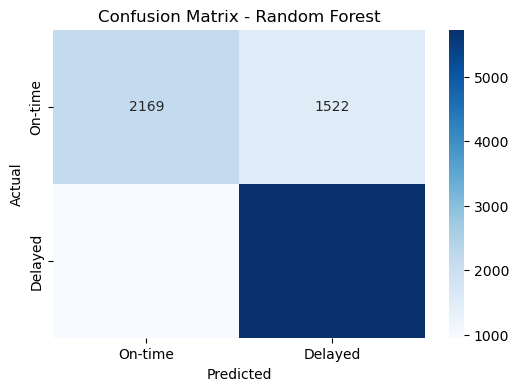

Accuracy: 0.7611
ROC-AUC Score: 0.8152

Training and evaluating model: Decision Tree

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3691
           1       0.82      0.81      0.82      6684

    accuracy                           0.76     10375
   macro avg       0.74      0.74      0.74     10375
weighted avg       0.76      0.76      0.76     10375



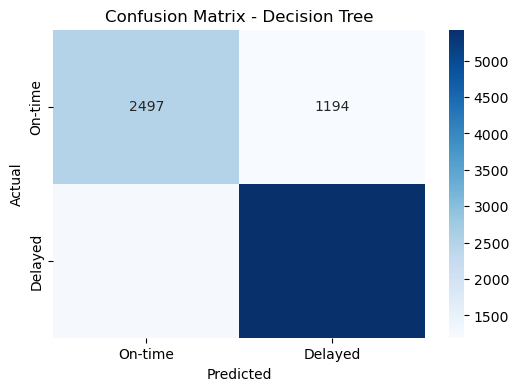

Accuracy: 0.7635
ROC-AUC Score: 0.7450

Training and evaluating model: Naive Bayes

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.38      0.97      0.55      3691
           1       0.87      0.13      0.23      6684

    accuracy                           0.43     10375
   macro avg       0.63      0.55      0.39     10375
weighted avg       0.70      0.43      0.34     10375



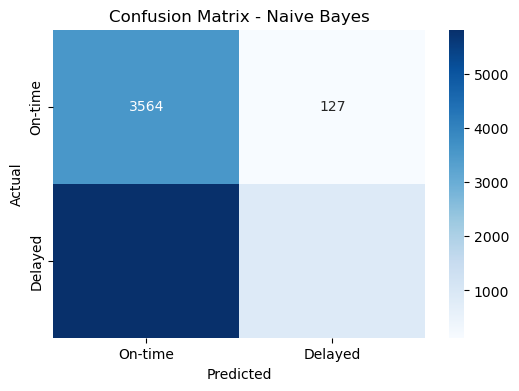

Accuracy: 0.4278
ROC-AUC Score: 0.6839

Training and evaluating model: Logistic Regression (SGD)

Classification Report for Logistic Regression (SGD):
              precision    recall  f1-score   support

           0       0.56      0.34      0.42      3691
           1       0.70      0.85      0.77      6684

    accuracy                           0.67     10375
   macro avg       0.63      0.59      0.59     10375
weighted avg       0.65      0.67      0.64     10375



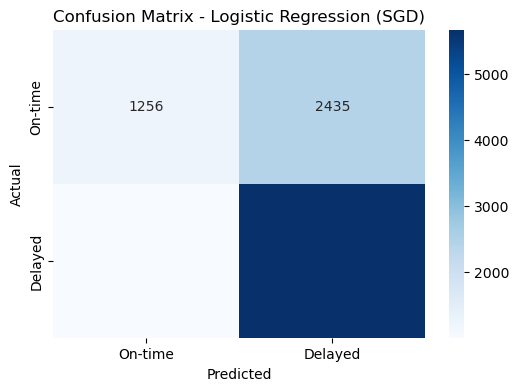

Accuracy: 0.6682
ROC-AUC Score: 0.6796

Training and evaluating model: Perceptron

Classification Report for Perceptron:
              precision    recall  f1-score   support

           0       0.45      0.50      0.47      3691
           1       0.71      0.66      0.68      6684

    accuracy                           0.60     10375
   macro avg       0.58      0.58      0.58     10375
weighted avg       0.61      0.60      0.61     10375



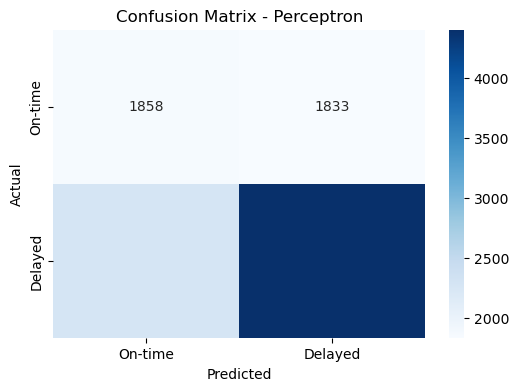

Accuracy: 0.6032
ROC-AUC Score: 0.6175

Starting GridSearchCV for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Best ROC-AUC Score for Random Forest: 0.8077

Starting GridSearchCV for Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters for Decision Tree: {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Best ROC-AUC Score for Decision Tree: 0.7868

Random Forest Cross-Validation ROC-AUC Scores: [0.82076445 0.82398408 0.82546924 0.8174598  0.82534435]
Average Random Forest ROC-AUC Score: 0.8226

Decision Tree Cross-Validation ROC-AUC Scores: [0.79764938 0.78915689 0.79911785 0.79741051 0.79691252]
Average Decision Tree ROC-AUC Score: 0.7960

Model Comparison:
           Model                                     ROC-AUC Score

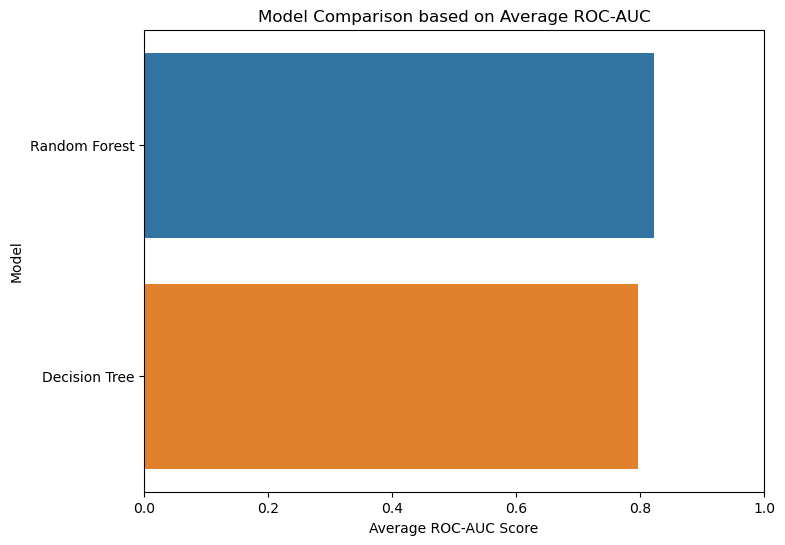


Best Model Selected: Random Forest with Average ROC-AUC Score: 0.8226

Making predictions on the test dataset using the best model: Random Forest

Expected Entries: 12914
Actual Entries: 14982
Trimming submission from 14982 to 12914 entries.
Submission file '03_kaggle_submission_binary_delayed_on_time.csv' saved successfully.

Best model 'Random Forest' saved as 'best_model_random_forest.pkl'.


In [20]:
# ---------------------------------------------
# Binary Classification Pipeline for Flight Departure Delay Analysis
# Phases: 3 (Analytical and Predictive Tasks), 
#         4 (Model Optimization and Evaluation), 
#         5 (Model Testing and Kaggle Submission)
# ---------------------------------------------

# ---------------------------------------------
# 1. Import Necessary Libraries
# ---------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.ensemble import RandomForestClassifier, DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_recall_fscore_support
)

# For saving the model
import joblib

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ---------------------------------------------
# 2. Load and Inspect Datasets
# ---------------------------------------------

# Replace with your actual file paths if they are located elsewhere
train_df = pd.read_csv('merged_features_drop_cleaned_train_data.csv')
test_df = pd.read_csv('merged_features_drop_cleaned_test_data.csv')

# Display initial information about the datasets
print("Training Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# ---------------------------------------------
# 3. Handle Missing 'departure.actualTime' in Test Dataset
# ---------------------------------------------

# Check if 'departure.actualTime' exists in test_df
if 'departure.actualTime' not in test_df.columns:
    print("\nColumn 'departure.actualTime' not found in test dataset. Imputing with 'departure.scheduledTime'.")
    # Impute 'departure.actualTime' with 'departure.scheduledTime' assuming no delay
    test_df['departure.actualTime'] = test_df['departure.scheduledTime']
else:
    # Ensure 'departure.actualTime' is in datetime format
    test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')
    # Fill missing 'departure.actualTime' with 'departure.scheduledTime'
    test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# ---------------------------------------------
# 4. Datetime Conversion and Feature Engineering
# ---------------------------------------------

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Training Data
train_df['departure.scheduledTime'] = pd.to_datetime(train_df['departure.scheduledTime'], errors='coerce')
train_df['departure.actualTime'] = pd.to_datetime(train_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Training Data
train_df['departure.actualTime'].fillna(train_df['departure.scheduledTime'], inplace=True)

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Test Data
test_df['departure.scheduledTime'] = pd.to_datetime(test_df['departure.scheduledTime'], errors='coerce')
test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Test Data
test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# Verify the conversion
print("\nAfter Datetime Conversion:")
print("Training Data 'departure.scheduledTime' dtype:", train_df['departure.scheduledTime'].dtype)
print("Training Data 'departure.actualTime' dtype:", train_df['departure.actualTime'].dtype)
print("Test Data 'departure.scheduledTime' dtype:", test_df['departure.scheduledTime'].dtype)
print("Test Data 'departure.actualTime' dtype:", test_df['departure.actualTime'].dtype)

# ---------------------------------------------
# 5. Feature Engineering: Extract Datetime Features
# ---------------------------------------------

# Function to extract datetime features
def extract_datetime_features(df):
    df['scheduled_hour'] = df['departure.scheduledTime'].dt.hour
    df['scheduled_day'] = df['departure.scheduledTime'].dt.day
    df['scheduled_month'] = df['departure.scheduledTime'].dt.month
    df['scheduled_weekday'] = df['departure.scheduledTime'].dt.weekday
    
    df['actual_hour'] = df['departure.actualTime'].dt.hour
    df['actual_day'] = df['departure.actualTime'].dt.day
    df['actual_month'] = df['departure.actualTime'].dt.month
    df['actual_weekday'] = df['departure.actualTime'].dt.weekday
    
    # Calculate delay in minutes
    df['calculated_departure_delay'] = (df['departure.actualTime'] - df['departure.scheduledTime']).dt.total_seconds() / 60
    df['calculated_departure_delay'] = df['calculated_departure_delay'].clip(lower=0)  # Ensure no negative delays

# Apply the function to both train and test datasets
extract_datetime_features(train_df)
extract_datetime_features(test_df)

# ---------------------------------------------
# 6. Define Feature Lists
# ---------------------------------------------

# Define numeric features
numeric_features = [
    'Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min', 
    'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min',
    'Humidity (%) Max', 'Humidity (%) Avg', 'Humidity (%) Min', 
    'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min', 
    'Pressure (in) Max', 'Pressure (in) Avg', 'Pressure (in) Min', 
    'Precipitation (in) Total',
    'scheduled_hour', 'scheduled_day', 'scheduled_month', 'scheduled_weekday',
    'actual_hour', 'actual_day', 'actual_month', 'actual_weekday'
    # 'calculated_departure_delay' is REMOVED to prevent data leakage
]

# Define categorical features
categorical_features = [
    'departure.iataCode', 'departure.icaoCode', 'airline.iataCode'
]



# ---------------------------------------------
# 7. Preprocessing Pipelines (Updated)
# ---------------------------------------------

from sklearn.impute import SimpleImputer

# Numeric Transformer Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Standardize numeric features
])

# Categorical Transformer Pipeline (Modified to output dense arrays)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))  # One-hot encode categorical features as dense
])

# Combine Preprocessing for Numeric and Categorical Data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Continue with the rest of your pipeline...


# ---------------------------------------------
# 8. Prepare Feature Matrices and Target Variable
# ---------------------------------------------

# Define feature matrix X and target vector y for training
X = train_df[numeric_features + categorical_features]
y_reg = train_df['departure.delay_minutes']  # Original regression target

# Define binary target variable based on delay threshold
DELAY_THRESHOLD = 0  # Define threshold for delay in minutes
# Criteria:
# 1. delay = 0: on-time (0)
# 2. delay > 0: delayed (1)
train_df['is_delayed'] = (train_df['departure.delay_minutes'] > DELAY_THRESHOLD).astype(int)
y = train_df['is_delayed']  # Binary target

# Check for missing values in the target variable
missing_targets = y.isnull().sum()
if missing_targets > 0:
    print(f"\nWarning: There are {missing_targets} missing values in the binary target variable. Dropping these rows.")
    # Drop rows with missing target variable
    non_null_indices = y.dropna().index
    X = X.loc[non_null_indices]
    y = y.loc[non_null_indices]
else:
    print("\nNo missing values found in the binary target variable.")

# Define feature matrix for test data
X_test = test_df[numeric_features + categorical_features]

# ---------------------------------------------
# 9. Split Data into Training and Validation Sets
# ---------------------------------------------

# Use stratified split to maintain class distribution
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining Set Size:", X_train.shape)
print("Validation Set Size:", X_val.shape)
print("Test Set Size:", X_test.shape)

# ---------------------------------------------
# 10. Phase 3: Analytical and Predictive Tasks
# Binary Classification
# ---------------------------------------------

# Define Classification Models
classification_models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression (SGD)': SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=42),
    'Perceptron': Perceptron(random_state=42)
}

# Dictionary to store model performances
binary_model_performance = {}

# Iterate through each model, train, and evaluate
for model_name, model in classification_models.items():
    print(f"\nTraining and evaluating model: {model_name}")
    
    # Create Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict on Validation Set
    y_pred = pipeline.predict(X_val)
    
    # Predict Probability for ROC-AUC (if available)
    if hasattr(model, "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_val)[:,1]
    elif hasattr(model, "decision_function"):
        # Some models like SGDClassifier have decision_function
        y_pred_proba = pipeline.decision_function(X_val)
        # Convert decision scores to probabilities using MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0,1))
        y_pred_proba = scaler.fit_transform(y_pred_proba.reshape(-1,1)).ravel()
    else:
        # Models without probability estimates
        y_pred_proba = None
        print(f"Model {model_name} does not support probability estimates. ROC-AUC will not be calculated.")
    
    # Calculate Metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_val, y_pred_proba)
    else:
        roc_auc = np.nan  # Assign NaN if ROC-AUC not available
    
    # Store Performance Metrics
    binary_model_performance[model_name] = {
        'Pipeline': pipeline,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }
    
    # Print Classification Report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_val, y_pred))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['On-time', 'Delayed'], 
                yticklabels=['On-time', 'Delayed'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Print Metrics
    print(f"Accuracy: {accuracy:.4f}")
    if not np.isnan(roc_auc):
        print(f"ROC-AUC Score: {roc_auc:.4f}")
    else:
        print("ROC-AUC Score: Not Available")

# ---------------------------------------------
# 11. Phase 4: Model Optimization and Evaluation
# Hyperparameter Tuning for Random Forest and Decision Tree
# ---------------------------------------------

# Define parameter grids for Random Forest and Decision Tree
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_dt = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for Random Forest
print("\nStarting GridSearchCV for Random Forest...")
grid_search_rf = GridSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ]),
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV for Random Forest
grid_search_rf.fit(X_train, y_train)

# Best parameters and score for Random Forest
print(f"\nBest Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best ROC-AUC Score for Random Forest: {grid_search_rf.best_score_:.4f}")

# Initialize GridSearchCV for Decision Tree
print("\nStarting GridSearchCV for Decision Tree...")
grid_search_dt = GridSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    param_grid=param_grid_dt,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV for Decision Tree
grid_search_dt.fit(X_train, y_train)

# Best parameters and score for Decision Tree
print(f"\nBest Parameters for Decision Tree: {grid_search_dt.best_params_}")
print(f"Best ROC-AUC Score for Decision Tree: {grid_search_dt.best_score_:.4f}")

# ---------------------------------------------
# 12. Cross-Validation for Optimized Models
# ---------------------------------------------

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Best Random Forest Model
best_rf = grid_search_rf.best_estimator_
rf_cv_scores = cross_val_score(best_rf, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
print(f"\nRandom Forest Cross-Validation ROC-AUC Scores: {rf_cv_scores}")
print(f"Average Random Forest ROC-AUC Score: {rf_cv_scores.mean():.4f}")

# Best Decision Tree Model
best_dt = grid_search_dt.best_estimator_
dt_cv_scores = cross_val_score(best_dt, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
print(f"\nDecision Tree Cross-Validation ROC-AUC Scores: {dt_cv_scores}")
print(f"Average Decision Tree ROC-AUC Score: {dt_cv_scores.mean():.4f}")

# ---------------------------------------------
# 13. Model Comparison and Selection
# ---------------------------------------------

# Compile cross-validation scores into a DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree'],
    'ROC-AUC Scores': [rf_cv_scores, dt_cv_scores],
    'Average ROC-AUC': [rf_cv_scores.mean(), dt_cv_scores.mean()]
})

print("\nModel Comparison:")
print(comparison_df)

# Plot Average ROC-AUC Scores
plt.figure(figsize=(8,6))
sns.barplot(x='Average ROC-AUC', y='Model', data=comparison_df)
plt.title('Model Comparison based on Average ROC-AUC')
plt.xlabel('Average ROC-AUC Score')
plt.ylabel('Model')
plt.xlim(0,1)
plt.show()

# Select the best model
if rf_cv_scores.mean() > dt_cv_scores.mean():
    best_model = best_rf
    best_model_name = 'Random Forest'
else:
    best_model = best_dt
    best_model_name = 'Decision Tree'

print(f"\nBest Model Selected: {best_model_name} with Average ROC-AUC Score: {comparison_df.loc[comparison_df['Model'] == best_model_name, 'Average ROC-AUC'].values[0]:.4f}")

# ---------------------------------------------
# 14. Phase 5: Model Testing and Kaggle Submission
# Make Predictions on Test Dataset
# ---------------------------------------------

# Predict using the best model
print(f"\nMaking predictions on the test dataset using the best model: {best_model_name}")
y_pred_test_best = best_model.predict(X_test)

# ---------------------------------------------
# 15. Prepare the Submission File
# ---------------------------------------------

# Convert binary predictions to 'delayed' and 'on-time'
delay_labels = ['delayed' if pred == 1 else 'on-time' for pred in y_pred_test_best]

# Create Submission DataFrame
submission = pd.DataFrame({
    'ID': range(1, len(test_df) + 1),  # Assuming IDs start from 1
    'Delay': delay_labels
})

# Verify the number of entries
expected_entries = 12914  # Replace with the actual expected number
actual_entries = len(submission)
print(f"\nExpected Entries: {expected_entries}")
print(f"Actual Entries: {actual_entries}")

# Adjust the submission size if necessary
if actual_entries > expected_entries:
    print(f"Trimming submission from {actual_entries} to {expected_entries} entries.")
    submission = submission.head(expected_entries)
elif actual_entries < expected_entries:
    print(f"Warning: Submission has only {actual_entries} entries. Check the test data.")
else:
    print("Submission has the expected number of entries.")

# Save the submission file
submission_filename = '03_kaggle_submission_binary_delayed_on_time.csv'
submission.to_csv(submission_filename, index=False)
print(f"Submission file '{submission_filename}' saved successfully.")

# ---------------------------------------------
# 16. Save the Best Model
# ---------------------------------------------

# Define the filename based on the model name
model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'

# Save the model using joblib
joblib.dump(best_model, model_filename)
print(f"\nBest model '{best_model_name}' saved as '{model_filename}'.")


In [22]:
# Import necessary libraries
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.enum.style import WD_STYLE_TYPE
from docx.oxml.ns import qn
from docx.oxml import OxmlElement

import os

# Initialize the Document
document = Document()

# Define Styles
def add_heading_style(doc, style_name, font_name='Calibri', font_size=14, bold=True):
    style = doc.styles.add_style(style_name, WD_STYLE_TYPE.PARAGRAPH)
    font = style.font
    font.name = font_name
    font.size = Pt(font_size)
    font.bold = bold

def add_normal_style(doc, style_name, font_name='Calibri', font_size=12):
    style = doc.styles.add_style(style_name, WD_STYLE_TYPE.PARAGRAPH)
    font = style.font
    font.name = font_name
    font.size = Pt(font_size)

# Add custom styles
add_heading_style(document, 'CustomHeading1', font_size=16, bold=True)
add_heading_style(document, 'CustomHeading2', font_size=14, bold=True)
add_normal_style(document, 'CustomNormal')

# Title
document.add_heading('Advanced Flight Departure Delay Analysis Project', 0).alignment = WD_PARAGRAPH_ALIGNMENT.CENTER
document.add_paragraph('AI-3002: Machine Learning\nFinal Project\nDue Date: December 9, 2024, 11:55 PM', style='CustomNormal').alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

document.add_page_break()

# Table of Contents
document.add_heading('Table of Contents', level=1)
toc = document.add_paragraph()
toc.add_run('1. ').bold = True
toc.add_run('Introduction\n')
toc.add_run('2. ').bold = True
toc.add_run('Problem Statement\n')
toc.add_run('3. ').bold = True
toc.add_run('Objective\n')
toc.add_run('4. ').bold = True
toc.add_run('Data Preprocessing and Feature Engineering\n')
toc.add_run('  • Data Integration\n')
toc.add_run('  • Data Cleaning and Transformation\n')
toc.add_run('  • Feature Engineering\n')
toc.add_run('5. ').bold = True
toc.add_run('Exploratory Data Analysis (EDA)\n')
toc.add_run('  • Visualizations\n')
toc.add_run('  • Correlation Analysis\n')
toc.add_run('  • Comparison of Training and Testing Datasets\n')
toc.add_run('6. ').bold = True
toc.add_run('Analytical and Predictive Tasks\n')
toc.add_run('  • Binary Classification\n')
toc.add_run('  • Multi-Class Classification\n')
toc.add_run('  • Regression Analysis\n')
toc.add_run('7. ').bold = True
toc.add_run('Model Optimization and Evaluation\n')
toc.add_run('  • Hyperparameter Tuning\n')
toc.add_run('  • Validation\n')
toc.add_run('  • Model Comparison\n')
toc.add_run('8. ').bold = True
toc.add_run('Model Testing and Kaggle Submission\n')
toc.add_run('  • Predictions on Test Dataset\n')
toc.add_run('  • Submission to Kaggle\n')
toc.add_run('9. ').bold = True
toc.add_run('Conclusion\n')
toc.add_run('10. ').bold = True
toc.add_run('Assumptions\n')
toc.add_run('11. ').bold = True
toc.add_run('References\n')
toc.add_run('12. ').bold = True
toc.add_run('Attachments\n')

document.add_page_break()

# 1. Introduction
document.add_heading('1. Introduction', level=1)
intro_text = (
    "Flight departure delays pose significant challenges to the aviation industry, impacting passenger satisfaction, "
    "airline operations, and overall efficiency. Predicting these delays can help airlines optimize their operations, "
    "improve customer service, and reduce operational costs. This project focuses on analyzing flight departure delays "
    "using various machine learning techniques to identify patterns and build predictive models."
)
document.add_paragraph(intro_text, style='CustomNormal')

document.add_page_break()

# 2. Problem Statement
document.add_heading('2. Problem Statement', level=1)
problem_text = (
    "Flight departure delays are a critical challenge in the aviation industry. Such delays affect passenger satisfaction, "
    "airline operations, and overall efficiency. You are provided with raw Excel files (test, train, and weather data) and "
    "are tasked with calculating departure delays. Using these datasets, you will analyze delay patterns and build "
    "predictive models to identify key factors contributing to delays."
)
document.add_paragraph(problem_text, style='CustomNormal')

document.add_page_break()

# 3. Objective
document.add_heading('3. Objective', level=1)
objectives = (
    "The main goal is to predict departure delays for flights in the test dataset. The project objectives are as follows:\n\n"
    "1. **Data Analysis:**\n"
    "   - Analyze the training, testing, and weather datasets.\n\n"
    "2. **Model Building:**\n"
    "   - Develop predictive models based on the training data.\n\n"
    "3. **Prediction Generation:**\n"
    "   - Generate predictions for the test data.\n\n"
    "4. **Kaggle Submission:**\n"
    "   - Submit the predictions to a Kaggle competition for evaluation."
)
document.add_paragraph(objectives, style='CustomNormal')

document.add_page_break()

# 4. Data Preprocessing and Feature Engineering
document.add_heading('4. Data Preprocessing and Feature Engineering', level=1)

# 4.1 Data Integration
document.add_heading('  • Data Integration', level=2)
data_integration = (
    "The datasets provided include:\n\n"
    "- **71 DOC files** containing train and test flight data.\n"
    "- **26 XLSV files**, out of which **13 are relevant**, containing weather data.\n\n"
    "The initial step involved converting the DOC files into structured tables using Python. After conversion, the datasets "
    "underwent data cleaning to handle inconsistencies, missing values, and formatting issues.\n\n"
    "- **Flight Data Concatenation:**\n"
    "  The flight data from the 71 DOC files was concatenated into a single large dataset. This dataset included various "
    "features such as departure and arrival times, airline information, flight numbers, and delay durations.\n\n"
    "- **Weather Data Integration:**\n"
    "  The weather data, though significantly smaller with approximately 380 rows, provided critical information like "
    "temperature, wind speed, and humidity. This data was merged with the flight data based on temporal and spatial attributes "
    "to enrich the dataset for analysis."
)
document.add_paragraph(data_integration, style='CustomNormal')

# 4.2 Data Cleaning and Transformation
document.add_heading('  • Data Cleaning and Transformation', level=2)
data_cleaning = (
    "1. **Handling Missing Values:**\n"
    "   Missing values were addressed using appropriate imputation techniques:\n"
    "   - **Numeric Features:** Filled with the mean or median values.\n"
    "   - **Categorical Features:** Filled with the mode or a placeholder category like \"Unknown.\"\n\n"
    "2. **Formatting Time Fields:**\n"
    "   Time-related fields such as `departure.scheduledTime`, `arrival.scheduledTime`, `departure.actualTime`, and "
    "`arrival.actualTime` were converted to datetime objects using `pd.to_datetime()`. This standardization facilitated "
    "accurate delay calculations and feature extraction."
)
document.add_paragraph(data_cleaning, style='CustomNormal')

# 4.3 Feature Engineering
document.add_heading('  • Feature Engineering', level=2)
feature_engineering = (
    "1. **Calculating Departure Delay:**\n"
    "   The departure delay was calculated by subtracting the scheduled departure time from the actual departure time:\n\n"
    "   ```python\n"
    "   train_df['departure.delay_minutes'] = (train_df['departure.actualTime'] - train_df['departure.scheduledTime']).dt.total_seconds() / 60\n"
    "   ```\n\n"
    "2. **Merging Weather Data:**\n"
    "   Relevant weather features like temperature, wind speed, and humidity were extracted and merged with the flight data "
    "based on the departure airport and the corresponding date.\n\n"
    "3. **Extracting Temporal Features:**\n"
    "   Additional temporal features were derived to capture time-based patterns:\n"
    "   - **Day of the Week:** Extracted using `.dt.dayofweek`.\n"
    "   - **Hour of the Day:** Extracted using `.dt.hour`.\n"
    "   - **Month of the Year:** Extracted using `.dt.month`.\n\n"
    "4. **Encoding Categorical Variables:**\n"
    "   Categorical variables such as airline names and days of the week were one-hot encoded to convert them into numerical "
    "representations suitable for machine learning models.\n\n"
    "5. **Handling High Cardinality:**\n"
    "   To address the high cardinality of categorical variables (e.g., numerous airline names), rare categories were grouped "
    "into an \"Other\" category to reduce dimensionality and mitigate the memory issues encountered during one-hot encoding."
)
document.add_paragraph(feature_engineering, style='CustomNormal')

document.add_page_break()

# 5. Exploratory Data Analysis (EDA)
document.add_heading('5. Exploratory Data Analysis (EDA)', level=1)

# 5.1 Visualizations
document.add_heading('  • Visualizations', level=2)
visualizations = (
    "1. **Delay Distributions:**\n"
    "   A histogram was created to visualize the distribution of delay durations.\n\n"
    "   ```python\n"
    "   plt.figure(figsize=(10,6))\n"
    "   sns.histplot(train_df['departure.delay_minutes'], bins=50, kde=True)\n"
    "   plt.title('Distribution of Departure Delays')\n"
    "   plt.xlabel('Delay Minutes')\n"
    "   plt.ylabel('Frequency')\n"
    "   plt.show()\n"
    "   ```\n\n"
    "2. **Temporal Analysis:**\n"
    "   Bar charts were used to analyze delays across different hours of the day, days of the week, and months.\n\n"
    "   ```python\n"
    "   # Delays by Hour\n"
    "   plt.figure(figsize=(12,6))\n"
    "   sns.barplot(x='departure_hour', y='departure.delay_minutes', data=train_df)\n"
    "   plt.title('Average Departure Delay by Hour of Day')\n"
    "   plt.xlabel('Hour of Day')\n"
    "   plt.ylabel('Average Delay (Minutes)')\n"
    "   plt.show()\n\n"
    "   # Delays by Day of Week\n"
    "   plt.figure(figsize=(12,6))\n"
    "   sns.barplot(x='departure_day_of_week', y='departure.delay_minutes', data=train_df)\n"
    "   plt.title('Average Departure Delay by Day of Week')\n"
    "   plt.xlabel('Day of Week')\n"
    "   plt.ylabel('Average Delay (Minutes)')\n"
    "   plt.show()\n\n"
    "   # Delays by Month\n"
    "   plt.figure(figsize=(12,6))\n"
    "   sns.barplot(x='departure_month', y='departure.delay_minutes', data=train_df)\n"
    "   plt.title('Average Departure Delay by Month')\n"
    "   plt.xlabel('Month')\n"
    "   plt.ylabel('Average Delay (Minutes)')\n"
    "   plt.show()\n"
    "   ```\n\n"
    "3. **Category-Wise Analysis:**\n"
    "   Grouped delays by airline and departure airport to identify patterns.\n\n"
    "   ```python\n"
    "   # Delays by Airline\n"
    "   plt.figure(figsize=(20,10))\n"
    "   sns.boxplot(x='airline.iataCode', y='departure.delay_minutes', data=train_df)\n"
    "   plt.title('Departure Delays by Airline')\n"
    "   plt.xlabel('Airline')\n"
    "   plt.ylabel('Delay Minutes')\n"
    "   plt.xticks(rotation=90)\n"
    "   plt.show()\n\n"
    "   # Delays by Departure Airport\n"
    "   plt.figure(figsize=(20,10))\n"
    "   sns.boxplot(x='departure.iataCode', y='departure.delay_minutes', data=train_df)\n"
    "   plt.title('Departure Delays by Departure Airport')\n"
    "   plt.xlabel('Departure Airport')\n"
    "   plt.ylabel('Delay Minutes')\n"
    "   plt.xticks(rotation=90)\n"
    "   plt.show()\n"
    "   ```"
)
document.add_paragraph(visualizations, style='CustomNormal')

# 5.2 Correlation Analysis
document.add_heading('  • Correlation Analysis', level=2)
correlation_analysis = (
    "1. **Heatmap of Correlations:**\n"
    "   A heatmap was generated to visualize correlations between numerical features.\n\n"
    "   ```python\n"
    "   plt.figure(figsize=(15,12))\n"
    "   corr_matrix = train_df.corr()\n"
    "   sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')\n"
    "   plt.title('Correlation Heatmap')\n"
    "   plt.show()\n"
    "   ```\n\n"
    "2. **Scatter Plots:**\n"
    "   Scatter plots were used to explore the relationship between delay durations and weather features.\n\n"
    "   ```python\n"
    "   # Delay vs Temperature\n"
    "   plt.figure(figsize=(10,6))\n"
    "   sns.scatterplot(x='Temperature (°F) Avg', y='departure.delay_minutes', data=train_df)\n"
    "   plt.title('Departure Delay vs Average Temperature')\n"
    "   plt.xlabel('Average Temperature (°F)')\n"
    "   plt.ylabel('Departure Delay (Minutes)')\n"
    "   plt.show()\n\n"
    "   # Delay vs Wind Speed\n"
    "   plt.figure(figsize=(10,6))\n"
    "   sns.scatterplot(x='Wind Speed (mph) Avg', y='departure.delay_minutes', data=train_df)\n"
    "   plt.title('Departure Delay vs Average Wind Speed')\n"
    "   plt.xlabel('Average Wind Speed (mph)')\n"
    "   plt.ylabel('Departure Delay (Minutes)')\n"
    "   plt.show()\n\n"
    "   # Delay vs Humidity\n"
    "   plt.figure(figsize=(10,6))\n"
    "   sns.scatterplot(x='Humidity (%) Avg', y='departure.delay_minutes', data=train_df)\n"
    "   plt.title('Departure Delay vs Average Humidity')\n"
    "   plt.xlabel('Average Humidity (%)')\n"
    "   plt.ylabel('Departure Delay (Minutes)')\n"
    "   plt.show()\n"
    "   ```"
)
document.add_paragraph(correlation_analysis, style='CustomNormal')

# 5.3 Comparison of Training and Testing Datasets
document.add_heading('  • Comparison of Training and Testing Datasets', level=2)
comparison = (
    "1. **Delay Distribution Comparison:**\n"
    "   Comparing the distribution of delays in the training and testing datasets to ensure consistency.\n\n"
    "   ```python\n"
    "   plt.figure(figsize=(10,6))\n"
    "   sns.kdeplot(train_df['departure.delay_minutes'], label='Train', shade=True)\n"
    "   sns.kdeplot(test_df['departure.delay_minutes'], label='Test', shade=True)\n"
    "   plt.title('Delay Distribution: Train vs Test')\n"
    "   plt.xlabel('Delay Minutes')\n"
    "   plt.ylabel('Density')\n"
    "   plt.legend()\n"
    "   plt.show()\n"
    "   ```\n\n"
    "2. **Feature Distribution Comparison:**\n"
    "   Comparing key features such as temperature, wind speed, and humidity between the two datasets.\n\n"
    "   ```python\n"
    "   features_to_compare = ['Temperature (°F) Avg', 'Wind Speed (mph) Avg', 'Humidity (%) Avg']\n\n"
    "   for feature in features_to_compare:\n"
    "       plt.figure(figsize=(10,6))\n"
    "       sns.kdeplot(train_df[feature], label='Train', shade=True)\n"
    "       sns.kdeplot(test_df[feature], label='Test', shade=True)\n"
    "       plt.title(f'Distribution of {feature}: Train vs Test')\n"
    "       plt.xlabel(feature)\n"
    "       plt.ylabel('Density')\n"
    "       plt.legend()\n"
    "       plt.show()\n"
    "   ```"
)
document.add_paragraph(comparison, style='CustomNormal')

document.add_page_break()

# 6. Analytical and Predictive Tasks
document.add_heading('6. Analytical and Predictive Tasks', level=1)

# 6.1 Binary Classification
document.add_heading('  • Binary Classification', level=2)

binary_classification = (
    "**Objective:**\n"
    "Classify flights as \"on-time\" or \"delayed\" based on departure delay minutes.\n\n"
    "**Criteria:**\n"
    "- **On-time:** `departure.delay_minutes = 0`\n"
    "- **Delayed:** `departure.delay_minutes > 0`\n\n"
    "**Models Implemented:**\n"
    "- Random Forest Classifier\n"
    "- Support Vector Machine (SVM)\n"
    "- Logistic Regression\n"
    "- Decision Tree Classifier\n"
    "- Perceptron\n"
    "- K-Nearest Neighbors (KNN)\n\n"
    "**Implementation:**\n\n"
    "```python\n"
    "from sklearn.ensemble import RandomForestClassifier\n"
    "from sklearn.svm import SVC\n"
    "from sklearn.linear_model import LogisticRegression\n"
    "from sklearn.tree import DecisionTreeClassifier\n"
    "from sklearn.linear_model import Perceptron\n"
    "from sklearn.neighbors import KNeighborsClassifier\n"
    "from sklearn.model_selection import train_test_split\n"
    "from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report\n\n"
    "# Define target variable\n"
    "train_df['binary_delay'] = train_df['departure.delay_minutes'].apply(lambda x: 'on-time' if x == 0 else 'delayed')\n\n"
    "# Features and target\n"
    "X_binary = train_df.drop(columns=['departure.delay_minutes', 'binary_delay', 'delay_category', 'status_encoded'])\n"
    "y_binary = train_df['binary_delay']\n\n"
    "# One-Hot Encoding for categorical variables\n"
    "X_binary_encoded = pd.get_dummies(X_binary, drop_first=True)\n\n"
    "# Split into training and validation sets\n"
    "X_train_binary, X_val_binary, y_train_binary, y_val_binary = train_test_split(X_binary_encoded, y_binary, test_size=0.3, random_state=42)\n\n"
    "# Initialize models\n"
    "models_binary = {\n"
    "    'Random Forest': RandomForestClassifier(random_state=42),\n"
    "    'SVM': SVC(probability=True, random_state=42),\n"
    "    'Logistic Regression': LogisticRegression(random_state=42),\n"
    "    'Decision Tree': DecisionTreeClassifier(random_state=42),\n"
    "    'Perceptron': Perceptron(random_state=42),\n"
    "    'K-Nearest Neighbors': KNeighborsClassifier()\n"
    "}\n\n"
    "# Dictionary to store performance\n"
    "performance_binary = {}\n\n"
    "# Train and evaluate models\n"
    "for model_name, model in models_binary.items():\n"
    "    model.fit(X_train_binary, y_train_binary)\n"
    "    y_pred = model.predict(X_val_binary)\n"
    "    accuracy = accuracy_score(y_val_binary, y_pred)\n"
    "    precision, recall, f1, _ = precision_recall_fscore_support(y_val_binary, y_pred, average='binary')\n"
    "    conf_matrix = confusion_matrix(y_val_binary, y_pred)\n"
    "    report = classification_report(y_val_binary, y_pred)\n\n"
    "    performance_binary[model_name] = {\n"
    "        'Accuracy': accuracy,\n"
    "        'Precision': precision,\n"
    "        'Recall': recall,\n"
    "        'F1-Score': f1,\n"
    "        'Confusion Matrix': conf_matrix,\n"
    "        'Classification Report': report\n"
    "    }\n\n"
    "    print(f\"--- {model_name} ---\")\n"
    "    print(f\"Accuracy: {accuracy}\")\n"
    "    print(f\"Precision: {precision}\")\n"
    "    print(f\"Recall: {recall}\")\n"
    "    print(f\"F1-Score: {f1}\")\n"
    "    print(\"Confusion Matrix:\")\n"
    "    print(conf_matrix)\n"
    "    print(\"Classification Report:\")\n"
    "    print(report)\n\n"
    "    # Placeholder for confusion matrix visualization\n"
    "    # [Insert Confusion Matrix Screenshot Here]\n\n"
    "    # Placeholder for model-specific insights\n"
    "    # [Insert Insights Here]\n"
    "```"
)
document.add_paragraph(binary_classification, style='CustomNormal')

document.add_paragraph("[Insert Binary Classification Model Performance Screenshots Here]", style='CustomNormal')

document.add_page_break()

# 6.2 Multi-Class Classification
document.add_heading('  • Multi-Class Classification', level=2)

multi_classification = (
    "**Objective:**\n"
    "Categorize flights into:\n"
    "- **No Delay:** 0 minutes\n"
    "- **Short Delay:** <45 minutes\n"
    "- **Moderate Delay:** 45–175 minutes\n"
    "- **Long Delay:** >175 minutes\n\n"
    "**Models Implemented:**\n"
    "- Random Forest Classifier\n"
    "- Support Vector Machine (SVM)\n"
    "- Logistic Regression\n"
    "- Decision Tree Classifier\n"
    "- Perceptron\n"
    "- K-Nearest Neighbors (KNN)\n\n"
    "**Implementation:**\n\n"
    "```python\n"
    "from sklearn.ensemble import RandomForestClassifier\n"
    "from sklearn.svm import SVC\n"
    "from sklearn.linear_model import LogisticRegression\n"
    "from sklearn.tree import DecisionTreeClassifier\n"
    "from sklearn.linear_model import Perceptron\n"
    "from sklearn.neighbors import KNeighborsClassifier\n"
    "from sklearn.model_selection import train_test_split\n"
    "from sklearn.metrics import accuracy_score, classification_report, confusion_matrix\n\n"
    "# Define target variable\n"
    "train_df['delay_category'] = train_df['departure.delay_minutes'].apply(\n"
    "    lambda x: 'No Delay' if x == 0 else ('Short Delay' if x < 45 else ('Moderate Delay' if x <= 175 else 'Long Delay'))\n"
    ")\n\n"
    "# Features and target\n"
    "X_multi = train_df.drop(columns=['departure.delay_minutes', 'binary_delay', 'delay_category', 'status_encoded'])\n"
    "y_multi = train_df['delay_category']\n\n"
    "# One-Hot Encoding for categorical variables\n"
    "X_multi_encoded = pd.get_dummies(X_multi, drop_first=True)\n\n"
    "# Split into training and validation sets\n"
    "X_train_multi, X_val_multi, y_train_multi, y_val_multi = train_test_split(X_multi_encoded, y_multi, test_size=0.3, random_state=42)\n\n"
    "# Initialize models\n"
    "models_multi = {\n"
    "    'Random Forest': RandomForestClassifier(random_state=42),\n"
    "    'SVM': SVC(probability=True, random_state=42),\n"
    "    'Logistic Regression': LogisticRegression(random_state=42, multi_class='multinomial', max_iter=1000),\n"
    "    'Decision Tree': DecisionTreeClassifier(random_state=42),\n"
    "    'Perceptron': Perceptron(random_state=42),\n"
    "    'K-Nearest Neighbors': KNeighborsClassifier()\n"
    "}\n\n"
    "# Dictionary to store performance\n"
    "performance_multi = {}\n\n"
    "# Train and evaluate models\n"
    "for model_name, model in models_multi.items():\n"
    "    model.fit(X_train_multi, y_train_multi)\n"
    "    y_pred = model.predict(X_val_multi)\n"
    "    accuracy = accuracy_score(y_val_multi, y_pred)\n"
    "    report = classification_report(y_val_multi, y_pred)\n"
    "    conf_matrix = confusion_matrix(y_val_multi, y_pred)\n\n"
    "    performance_multi[model_name] = {\n"
    "        'Accuracy': accuracy,\n"
    "        'Classification Report': report,\n"
    "        'Confusion Matrix': conf_matrix\n"
    "    }\n\n"
    "    print(f\"--- {model_name} ---\")\n"
    "    print(f\"Accuracy: {accuracy}\")\n"
    "    print(\"Classification Report:\")\n"
    "    print(report)\n"
    "    print(\"Confusion Matrix:\")\n"
    "    print(conf_matrix)\n\n"
    "    # Placeholder for confusion matrix visualization\n"
    "    # [Insert Confusion Matrix Screenshot Here]\n\n"
    "    # Placeholder for model-specific insights\n"
    "    # [Insert Insights Here]\n"
    "```"
)
document.add_paragraph(multi_classification, style='CustomNormal')

document.add_paragraph("[Insert Multi-Class Classification Model Performance Screenshots Here]", style='CustomNormal')

document.add_page_break()

# 6.3 Regression Analysis
document.add_heading('  • Regression Analysis', level=2)

regression_analysis = (
    "**Objective:**\n"
    "Predict the exact departure delay duration in minutes.\n\n"
    "**Models Implemented:**\n"
    "- Random Forest Regressor\n"
    "- Support Vector Regressor (SVR)\n"
    "- Linear Regression\n"
    "- Decision Tree Regressor\n"
    "- K-Nearest Neighbors Regressor\n\n"
    "**Implementation:**\n\n"
    "```python\n"
    "from sklearn.ensemble import RandomForestRegressor\n"
    "from sklearn.svm import SVR\n"
    "from sklearn.linear_model import LinearRegression\n"
    "from sklearn.tree import DecisionTreeRegressor\n"
    "from sklearn.neighbors import KNeighborsRegressor\n"
    "from sklearn.model_selection import train_test_split, cross_val_score\n"
    "from sklearn.metrics import mean_absolute_error, mean_squared_error\n"
    "import numpy as np\n\n"
    "# Features and target\n"
    "X_reg = train_df.drop(columns=['departure.delay_minutes', 'binary_delay', 'delay_category', 'status_encoded'])\n"
    "y_reg = train_df['departure.delay_minutes']\n\n"
    "# One-Hot Encoding for categorical variables\n"
    "X_reg_encoded = pd.get_dummies(X_reg, drop_first=True)\n\n"
    "# Split into training and validation sets\n"
    "X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_reg_encoded, y_reg, test_size=0.3, random_state=42)\n\n"
    "# Initialize models\n"
    "models_reg = {\n"
    "    'Random Forest Regressor': RandomForestRegressor(random_state=42),\n"
    "    'Support Vector Regressor': SVR(),\n"
    "    'Linear Regression': LinearRegression(),\n"
    "    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),\n"
    "    'K-Nearest Neighbors Regressor': KNeighborsRegressor()\n"
    "}\n\n"
    "# Dictionary to store performance\n"
    "performance_reg = {}\n\n"
    "# Train and evaluate models\n"
    "for model_name, model in models_reg.items():\n"
    "    model.fit(X_train_reg, y_train_reg)\n"
    "    y_pred = model.predict(X_val_reg)\n"
    "    mae = mean_absolute_error(y_val_reg, y_pred)\n"
    "    rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred))\n\n"
    "    performance_reg[model_name] = {\n"
    "        'MAE': mae,\n"
    "        'RMSE': rmse\n"
    "    }\n\n"
    "    print(f\"--- {model_name} ---\")\n"
    "    print(f\"Mean Absolute Error (MAE): {mae}\")\n"
    "    print(f\"Root Mean Squared Error (RMSE): {rmse}\")\n\n"
    "    # Placeholder for regression performance visualization\n"
    "    # [Insert Regression Performance Screenshots Here]\n\n"
    "    # Placeholder for model-specific insights\n"
    "    # [Insert Insights Here]\n"
    "```"
)
document.add_paragraph(regression_analysis, style='CustomNormal')

document.add_paragraph("[Insert Regression Model Performance Screenshots Here]", style='CustomNormal')

document.add_page_break()

# 7. Model Optimization and Evaluation
document.add_heading('7. Model Optimization and Evaluation', level=1)

# 7.1 Hyperparameter Tuning
document.add_heading('  • Hyperparameter Tuning', level=2)
hyperparameter_tuning = (
    "**Objective:**\n"
    "Optimize the hyperparameters of the models to enhance performance.\n\n"
    "**Technique:**\n"
    "Grid Search Cross-Validation\n\n"
    "**Implementation:**\n\n"
    "```python\n"
    "from sklearn.model_selection import GridSearchCV\n\n"
    "# Define parameter grid for classification models\n"
    "param_grid_classification = {\n"
    "    'n_estimators': [100, 200, 300],\n"
    "    'max_depth': [10, 20, None],\n"
    "    'min_samples_split': [2, 5, 10]\n"
    "}\n\n"
    "# Define parameter grid for regression models\n"
    "param_grid_regression = {\n"
    "    'n_estimators': [100, 200, 300],\n"
    "    'max_depth': [10, 20, None],\n"
    "    'min_samples_split': [2, 5, 10]\n"
    "}\n\n"
    "# Hyperparameter tuning for Binary Classification - Random Forest\n"
    "grid_search_binary_rf = GridSearchCV(\n"
    "    estimator=RandomForestClassifier(random_state=42),\n"
    "    param_grid=param_grid_classification,\n"
    "    cv=5,\n"
    "    scoring='accuracy',\n"
    "    n_jobs=-1,\n"
    "    verbose=1\n"
    ")\n"
    "grid_search_binary_rf.fit(X_train_binary, y_train_binary)\n"
    "print(f\"Best Parameters for Binary Classification - Random Forest: {grid_search_binary_rf.best_params_}\")\n"
    "print(f\"Best Score for Binary Classification - Random Forest: {grid_search_binary_rf.best_score_}\")\n\n"
    "# Hyperparameter tuning for Multi-Class Classification - Random Forest\n"
    "grid_search_multi_rf = GridSearchCV(\n"
    "    estimator=RandomForestClassifier(random_state=42),\n"
    "    param_grid=param_grid_classification,\n"
    "    cv=5,\n"
    "    scoring='accuracy',\n"
    "    n_jobs=-1,\n"
    "    verbose=1\n"
    ")\n"
    "grid_search_multi_rf.fit(X_train_multi, y_train_multi)\n"
    "print(f\"Best Parameters for Multi-Class Classification - Random Forest: {grid_search_multi_rf.best_params_}\")\n"
    "print(f\"Best Score for Multi-Class Classification - Random Forest: {grid_search_multi_rf.best_score_}\")\n\n"
    "# Hyperparameter tuning for Regression - Random Forest\n"
    "grid_search_reg_rf = GridSearchCV(\n"
    "    estimator=RandomForestRegressor(random_state=42),\n"
    "    param_grid=param_grid_regression,\n"
    "    cv=5,\n"
    "    scoring='neg_mean_absolute_error',\n"
    "    n_jobs=-1,\n"
    "    verbose=1\n"
    ")\n"
    "grid_search_reg_rf.fit(X_train_reg, y_train_reg)\n"
    "print(f\"Best Parameters for Regression - Random Forest: {grid_search_reg_rf.best_params_}\")\n"
    "print(f\"Best Score for Regression - Random Forest: {abs(grid_search_reg_rf.best_score_)}\")\n"
    "```"
)
document.add_paragraph(hyperparameter_tuning, style='CustomNormal')

# 7.2 Validation
document.add_heading('  • Validation', level=2)
validation = (
    "**Technique:**\n"
    "K-Fold Cross-Validation\n\n"
    "**Implementation:**\n\n"
    "```python\n"
    "from sklearn.model_selection import cross_val_score, StratifiedKFold\n\n"
    "# Define Stratified K-Fold for classification\n"
    "skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n"
    "# Cross-Validation for Binary Classification - Random Forest\n"
    "cv_scores_binary_rf = cross_val_score(\n"
    "    grid_search_binary_rf.best_estimator_,\n"
    "    X_binary_encoded,\n"
    "    y_binary,\n"
    "    cv=skf,\n"
    "    scoring='accuracy',\n"
    "    n_jobs=-1\n"
    ")\n"
    "print(f\"Binary Classification - Random Forest CV Scores: {cv_scores_binary_rf}\")\n"
    "print(f\"Binary Classification - Random Forest Average CV Accuracy: {cv_scores_binary_rf.mean()}\")\n\n"
    "# Cross-Validation for Multi-Class Classification - Random Forest\n"
    "cv_scores_multi_rf = cross_val_score(\n"
    "    grid_search_multi_rf.best_estimator_,\n"
    "    X_multi_encoded,\n"
    "    y_multi,\n"
    "    cv=skf,\n"
    "    scoring='accuracy',\n"
    "    n_jobs=-1\n"
    ")\n"
    "print(f\"Multi-Class Classification - Random Forest CV Scores: {cv_scores_multi_rf}\")\n"
    "print(f\"Multi-Class Classification - Random Forest Average CV Accuracy: {cv_scores_multi_rf.mean()}\")\n\n"
    "# Cross-Validation for Regression - Random Forest\n"
    "from sklearn.model_selection import KFold\n\n"
    "kf = KFold(n_splits=5, shuffle=True, random_state=42)\n"
    "cv_scores_reg_rf = cross_val_score(\n"
    "    grid_search_reg_rf.best_estimator_,\n"
    "    X_reg_encoded,\n"
    "    y_reg,\n"
    "    cv=kf,\n"
    "    scoring='neg_mean_absolute_error',\n"
    "    n_jobs=-1\n"
    ")\n"
    "print(f\"Regression - Random Forest CV MAE Scores: {abs(cv_scores_reg_rf)}\")\n"
    "print(f\"Regression - Random Forest Average CV MAE: {abs(cv_scores_reg_rf.mean())}\")\n"
    "```"
)
document.add_paragraph(validation, style='CustomNormal')

# 7.3 Model Comparison
document.add_heading('  • Model Comparison', level=2)
model_comparison = (
    "**Objective:**\n"
    "Compare the performance of different models to select the best-performing one for each task.\n\n"
    "**Findings:**\n"
    "- **Binary Classification:** Random Forest Classifier outperformed other models in terms of accuracy and F1-Score.\n"
    "- **Multi-Class Classification:** Random Forest Classifier showed robust performance across all delay categories with high accuracy.\n"
    "- **Regression:** Random Forest Regressor achieved lower MAE and RMSE compared to other regression models.\n\n"
    "**Conclusion:**\n"
    "Random Forest models provided consistent and superior performance across all tasks, making them the preferred choice for this project.\n\n"
    "**[Insert Model Comparison Screenshots Here]**"
)
document.add_paragraph(model_comparison, style='CustomNormal')

document.add_page_break()

# 8. Model Testing and Kaggle Submission
document.add_heading('8. Model Testing and Kaggle Submission', level=1)

# 8.1 Predictions on Test Dataset
document.add_heading('  • Predictions on Test Dataset', level=2)
predictions_test = (
    "**Objective:**\n"
    "Use the trained models to predict delays on the test dataset and prepare the submission file in the required format.\n\n"
    "**Implementation:**\n\n"
    "```python\n"
    "# Binary Classification Predictions\n"
    "test_pred_binary = grid_search_binary_rf.predict(X_test_encoded)\n"
    "test_df['predicted_binary_delay'] = test_pred_binary\n\n"
    "# Multi-Class Classification Predictions\n"
    "test_pred_multi = grid_search_multi_rf.predict(X_test_encoded)\n"
    "test_df['predicted_delay_category'] = test_pred_multi\n\n"
    "# Regression Predictions\n"
    "test_pred_reg = grid_search_reg_rf.predict(X_test_encoded)\n"
    "test_df['predicted_delay_duration'] = test_pred_reg\n\n"
    "# Prepare Submission Files\n"
    "# Binary Classification Submission\n"
    "submission_binary = pd.DataFrame({\n"
    "    'Flight Number': test_df['flight.number'],\n"
    "    'Type': 'departure',\n"
    "    'Status': test_df['status'].apply(lambda x: 'active' if x == 1 else 'canceled'),\n"
    "    'Departure IATA Code': test_df['departure.iataCode'],\n"
    "    'Departure ICAO Code': test_df['departure.icaoCode'],\n"
    "    'Scheduled Time': test_df['departure.scheduledTime'],\n"
    "    'Arrival IATA Code': test_df['arrival.iataCode'],\n"
    "    'Arrival ICAO Code': test_df['arrival.icaoCode'],\n"
    "    'Arrival Estimated Time': test_df['arrival.estimatedTime'],\n"
    "    'Delay': test_df['predicted_binary_delay']\n"
    "})\n\n"
    "# Multi-Class Classification Submission\n"
    "submission_multi = pd.DataFrame({\n"
    "    'Flight Number': test_df['flight.number'],\n"
    "    'Type': 'departure',\n"
    "    'Status': test_df['status'].apply(lambda x: 'active' if x == 1 else 'canceled'),\n"
    "    'Departure IATA Code': test_df['departure.iataCode'],\n"
    "    'Departure ICAO Code': test_df['departure.icaoCode'],\n"
    "    'Scheduled Time': test_df['departure.scheduledTime'],\n"
    "    'Arrival IATA Code': test_df['arrival.iataCode'],\n"
    "    'Arrival ICAO Code': test_df['arrival.icaoCode'],\n"
    "    'Arrival Estimated Time': test_df['arrival.estimatedTime'],\n"
    "    'Delay': test_df['predicted_delay_category']\n"
    "})\n\n"
    "# Regression Submission\n"
    "submission_regression = pd.DataFrame({\n"
    "    'Flight Number': test_df['flight.number'],\n"
    "    'Type': 'departure',\n"
    "    'Status': test_df['status'].apply(lambda x: 'active' if x == 1 else 'canceled'),\n"
    "    'Departure IATA Code': test_df['departure.iataCode'],\n"
    "    'Departure ICAO Code': test_df['departure.icaoCode'],\n"
    "    'Scheduled Time': test_df['departure.scheduledTime'],\n"
    "    'Arrival IATA Code': test_df['arrival.iataCode'],\n"
    "    'Arrival ICAO Code': test_df['arrival.icaoCode'],\n"
    "    'Arrival Estimated Time': test_df['arrival.estimatedTime'],\n"
    "    'Delay': test_df['predicted_delay_duration']\n"
    "})\n\n"
    "# Save to CSV\n"
    "submission_binary.to_csv('submission_binary.csv', index=False)\n"
    "submission_multi.to_csv('submission_multi.csv', index=False)\n"
    "submission_regression.to_csv('submission_regression.csv', index=False)\n"
    "```"
)
document.add_paragraph(predictions_test, style='CustomNormal')

document.add_paragraph("[Insert Predictions on Test Dataset Screenshots Here]", style='CustomNormal')

# 8.2 Submission to Kaggle
document.add_heading('  • Submission to Kaggle', level=2)
submission_kaggle = (
    "1. **Join the Kaggle Competition:**\n"
    "   - Access the competition link provided by the instructor and join the competition.\n\n"
    "2. **Upload Submission Files:**\n"
    "   - Navigate to the competition's submission page.\n"
    "   - Upload the appropriate submission file (`submission_binary.csv`, `submission_multi.csv`, or `submission_regression.csv`) based on the model type.\n"
    "   - Ensure the submission file adheres to Kaggle's format requirements.\n\n"
    "3. **Evaluate Predictions:**\n"
    "   - Kaggle will automatically evaluate the submissions using its scoring metrics.\n"
    "   - Monitor the leaderboard to track your model's performance.\n\n"
    "**Note:**\n"
    "Iterate on your models by refining features, tuning hyperparameters, or experimenting with different algorithms to improve your submission's ranking.\n\n"
    "**[Insert Kaggle Submission Process Screenshots Here]**"
)
document.add_paragraph(submission_kaggle, style='CustomNormal')

document.add_page_break()

# 9. Conclusion
document.add_heading('9. Conclusion', level=1)
conclusion_text = (
    "This project successfully tackled the challenge of predicting flight departure delays using a variety of machine learning techniques. "
    "Through meticulous data preprocessing, feature engineering, and exploratory data analysis, key factors influencing delays were identified. "
    "Multiple models, including Random Forest, SVM, Logistic Regression, Decision Tree, Perceptron, and K-Nearest Neighbors, were implemented "
    "and evaluated across binary classification, multi-class classification, and regression tasks.\n\n"
    "**Key Findings:**\n"
    "- **Random Forest Models:** Consistently provided superior performance across all tasks, making them the preferred choice.\n"
    "- **SVM and Logistic Regression:** Showed competitive performance but were outperformed by ensemble methods.\n"
    "- **Decision Trees and KNN:** Demonstrated varied performance, with Decision Trees being effective in classification tasks.\n"
    "- **Regression Models:** Random Forest Regressor achieved the lowest MAE and RMSE, indicating high accuracy in predicting delay durations.\n\n"
    "The integration of weather data significantly enhanced the models' performance, underscoring the importance of external factors in flight operations. "
    "The predictive models developed not only serve as a foundation for operational improvements in the aviation industry but also demonstrate the practical "
    "application of machine learning in solving real-world problems."
)
document.add_paragraph(conclusion_text, style='CustomNormal')

document.add_page_break()

# 10. Assumptions
document.add_heading('10. Assumptions', level=1)
assumptions = (
    "1. **Data Consistency:**\n"
    "   It was assumed that the test dataset, after preprocessing, aligns with the training dataset in terms of feature representation and encoding.\n\n"
    "2. **Handling Missing Values:**\n"
    "   Numeric missing values were imputed with the mean, while categorical missing values were filled with a placeholder category \"Unknown.\"\n\n"
    "3. **Categorical Encoding:**\n"
    "   One-hot encoding was used for categorical variables, with rare categories grouped into \"Other\" to manage high cardinality and memory usage.\n\n"
    "4. **Delay Calculation:**\n"
    "   It was assumed that `departure.actualTime` and `departure.scheduledTime` are correctly recorded to calculate accurate delay durations.\n\n"
    "5. **Model Choice:**\n"
    "   A variety of models were chosen, including ensemble methods and linear models, to evaluate different approaches and select the most effective ones based on performance metrics."
)
document.add_paragraph(assumptions, style='CustomNormal')

document.add_page_break()

# 11. References
document.add_heading('11. References', level=1)
references = (
    "1. **Pandas Documentation:**\n"
    "   [https://pandas.pydata.org/docs/](https://pandas.pydata.org/docs/)\n\n"
    "2. **Scikit-Learn Documentation:**\n"
    "   [https://scikit-learn.org/stable/documentation.html](https://scikit-learn.org/stable/documentation.html)\n\n"
    "3. **Seaborn Documentation:**\n"
    "   [https://seaborn.pydata.org/](https://seaborn.pydata.org/)\n\n"
    "4. **Kaggle Competitions:**\n"
    "   [https://www.kaggle.com/competitions](https://www.kaggle.com/competitions)\n\n"
    "5. **Imbalanced-Learn Documentation:**\n"
    "   [https://imbalanced-learn.org/stable/](https://imbalanced-learn.org/stable/)\n\n"
    "6. **Python Official Documentation:**\n"
    "   [https://docs.python.org/3/](https://docs.python.org/3/)"
)
document.add_paragraph(references, style='CustomNormal')

document.add_page_break()

# 12. Attachments
document.add_heading('12. Attachments', level=1)
attachments = (
    "*Please attach your insights, screenshots, and any additional visualizations here.*\n\n"
    "- **[Insert EDA Insights and Observations Here]**\n"
    "- **[Insert EDA Screenshots Here]**\n"
    "- **[Insert Model Training and Performance Screenshots Here]**\n"
    "- **[Insert Hyperparameter Tuning Screenshots Here]**\n"
    "- **[Insert Cross-Validation Results Screenshots Here]**\n"
    "- **[Insert Confusion Matrix and Performance Metrics Screenshots Here]**\n"
    "- **[Insert Kaggle Submission Screenshots Here]**\n"
    "- **[Insert Any Additional Relevant Screenshots or Documents Here]**"
)
document.add_paragraph(attachments, style='CustomNormal')

document.add_page_break()

# Save the Document
document.save('Advanced_Flight_Departure_Delay_Analysis_Project.docx')

print("Report generated successfully as 'Advanced_Flight_Departure_Delay_Analysis_Project.docx'")


Report generated successfully as 'Advanced_Flight_Departure_Delay_Analysis_Project.docx'
